In [94]:
# !pip install GDAL-3.1.4-cp39-cp39m-win_amd64.whl
# !pip install Fiona-1.8.17-cp39-cp39m-win_amd64.whl
# !pip install Shapely-1.7.1-cp39-cp39m-win_amd64.whl 
# !pip install geopandas

In [ ]:
# !pip install GDAL
# !pip install Fiona
# !pip install Shapely 
# !pip install geopandas
conda install -c conda-forge geopandas

In [4]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

<AxesSubplot:>

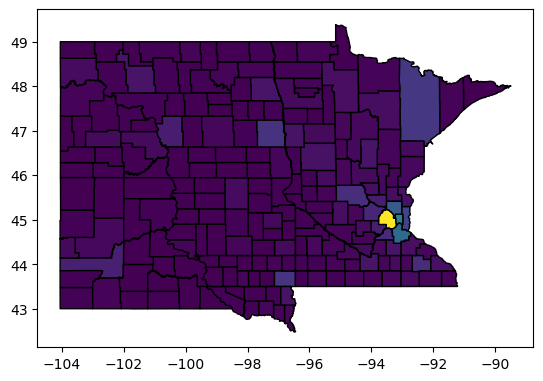

In [27]:
filename = "countiesWithStatesAndPopulation.shp"
index_col = "FIPS"
map_data = geopandas.read_file(filename = filename).set_index(["State", 
                                                               "NAME"])
map_plot_data = map_data.loc[["North Dakota", 
                              "South Dakota", 
                              "Minnesota"]]
map_plot_data.plot(column = "Population", 
                   cmap = "viridis",
                   alpha = 1, 
                   edgecolor = "k")
# map_plot_data.groupby("State").mean().plot(alpha = 1, linewidth = 10)

In [36]:
def import_geo_data(filename, FIPS_name = "FIPS"):
    map_data = geopandas.read_file(filename = filename).rename(
        columns = {"State":"state"})
    map_data[FIPS_name] = map_data["STATEFP"].astype(str) +\
        map_data["COUNTYFP"].astype(str)
    map_data[FIPS_name] = map_data[FIPS_name].astype(np.int64)
    map_data.set_index(FIPS_name, inplace = True)
    
    return map_data
map_data = import_geo_data(filename = filename, FIPS_name = index_col)
map_data

STATEFP COUNTYFP  COUNTYNS        AFFGEOID       NAME LSAD       ALAND  \
FIPS                                                                            
21007       21      007  00516850  0500000US21007    Ballard   06   639387454   
21017       21      017  00516855  0500000US21017    Bourbon   06   750439351   
21031       21      031  00516862  0500000US21031     Butler   06  1103571974   
21065       21      065  00516879  0500000US21065     Estill   06   655509930   
21069       21      069  00516881  0500000US21069    Fleming   06   902727151   
...        ...      ...       ...             ...        ...  ...         ...   
31073       31      073  00835858  0500000US31073     Gosper   06  1186616237   
39075       39      075  01074050  0500000US39075     Holmes   06  1094405866   
48171       48      171  01383871  0500000US48171  Gillespie   06  2740719114   
55079       55      079  01581100  0500000US55079  Milwaukee   06   625440563   
26139       26      139  01623012  0500000US26139     Ottawa   06  1459502408   

           AWATER  Population      state  \
FIPS                                       
21007    69473325      7888.0   Kentucky   
21017     4829777     19788.0   Kentucky   
21031    13943044     12879.0   Kentucky   
21065     6516335     14106.0   Kentucky   
21069     7182793     14581.0   Kentucky   
...           ...         ...        ...   
31073    11831826      1990.0   Nebraska   
39075     3695230     43960.0       Ohio   
48171     9012764     26988.0      Texas   
55079  2455383635    945726.0  Wisconsin   
26139  2765830983    291830.0   Michigan   

                                                geometry  
FIPS                                                      
21007  POLYGON ((-89.18137 37.04630, -89.17938 37.053...  
21017  POLYGON ((-84.44266 38.28324, -84.44114 38.283...  
21031  POLYGON ((-86.94486 37.07341, -86.94346 37.074...  
21065  POLYGON ((-84.12662 37.64540, -84.12483 37.646...  
21069  POLYGON ((-83.98428 38.44549, -83.98246 38.450...  
...                                                  ...  
31073  POLYGON ((-100.09510 40.43866, -100.08937 40.4...  
39075  POLYGON ((-82.22066 40.66758, -82.19327 40.667...  
48171  POLYGON ((-99.30400 30.49983, -99.28234 30.499...  
55079  POLYGON ((-88.06959 42.86726, -88.06959 42.872...  
26139  POLYGON ((-86.26432 43.11830, -86.25103 43.118...  

[3142 rows x 11 columns]

<AxesSubplot:>

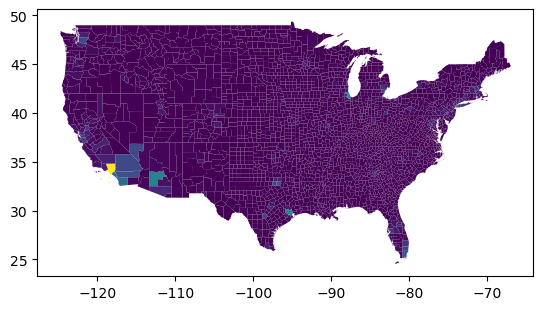

In [41]:
# plot only counties not in Hawaii or Alaska
map_data[~map_data["state"].isin(
    ["Hawaii", "Alaska"])].plot(column = "Population")

In [82]:
u_data = pd.read_csv("countyUnemploymentData.csv",
                    encoding = "latin1",
                    parse_dates = True,
                    index_col = ["date", "fips_code"])
u_data = u_data[list(u_data.keys())[-4:]]
u_data.dtypes

C:\Users\JLCat\AppData\Local\Temp\ipykernel_33604\1701343223.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  u_data = pd.read_csv("countyUnemploymentData.csv",


Labor Force          object
Employed             object
Unemployed           object
Unemployment Rate    object
dtype: object

In [83]:
for key in u_data.keys():
    u_data[key] = pd.to_numeric(u_data[key], errors = "coerce")
u_data.dtypes

Labor Force          float64
Employed             float64
Unemployed           float64
Unemployment Rate    float64
dtype: object

In [84]:
import copy as copy
def create_merged_geo_dataframe(data, map_data):
    data_frame_initialized = False
    matching_gpd = {}
    counties = data.groupby("fips_code").mean().index.unique()
    dates = data.groupby("date").mean().index.unique()
    for key, val in data.items():
        matching_gpd[key] = copy.copy(
            map_data[map_data.index.isin(counties)])
        for date in dates:
            val_slice = val.loc[date]
            val_slice.reset_index().set_index("fips_code")
            matching_gpd[key][date] = val_slice
    return matching_gpd
dates = u_data.groupby("date").mean().index.unique()
u_data = create_merged_geo_dataframe(u_data, map_data)

In [85]:
dates

DatetimeIndex(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01'],
              dtype='datetime64[ns]', name='date', freq=None)

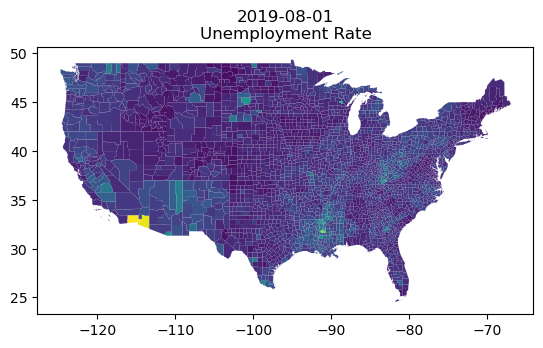

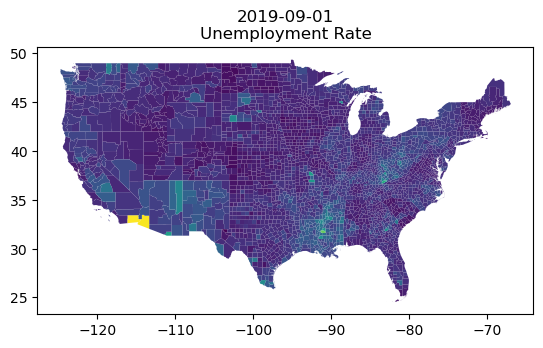

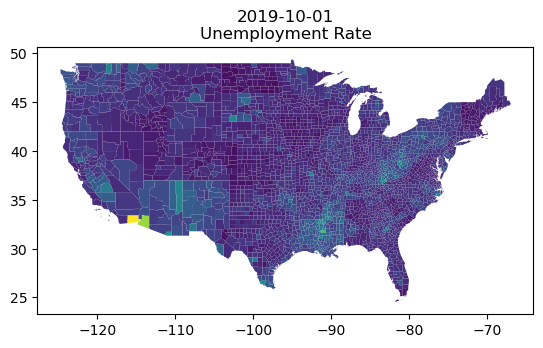

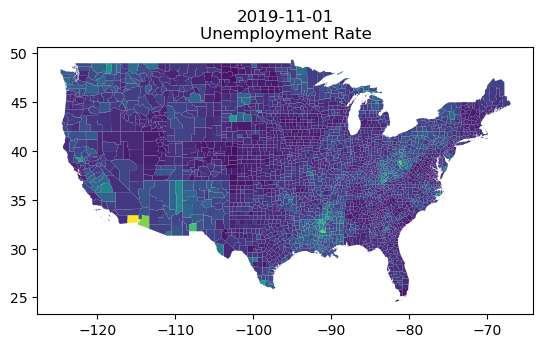

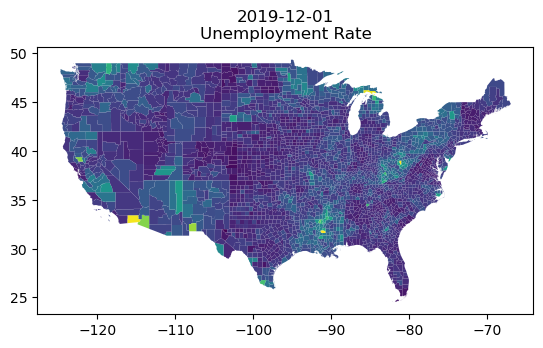

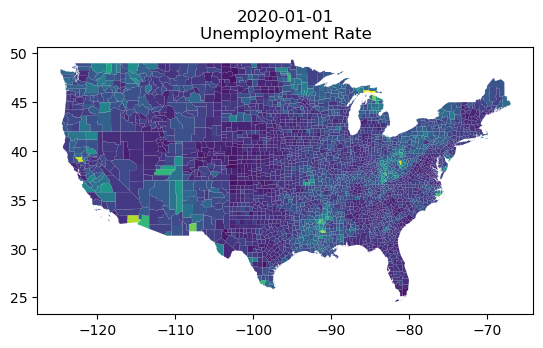

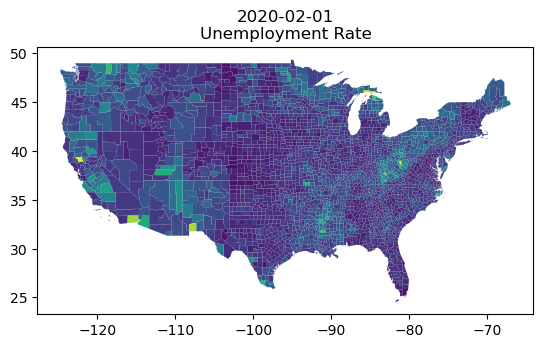

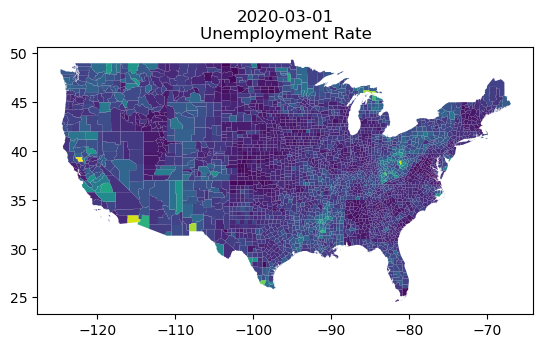

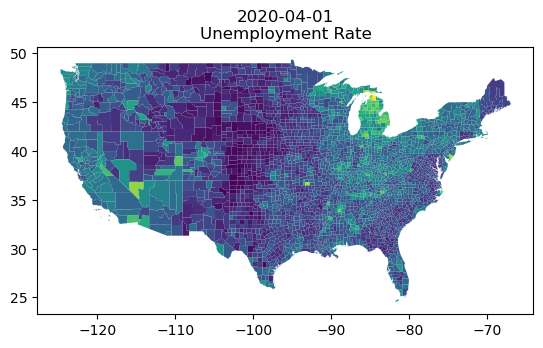

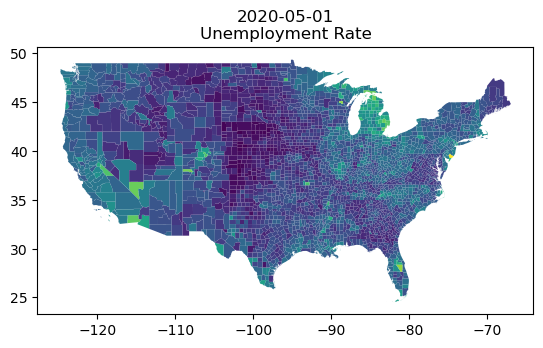

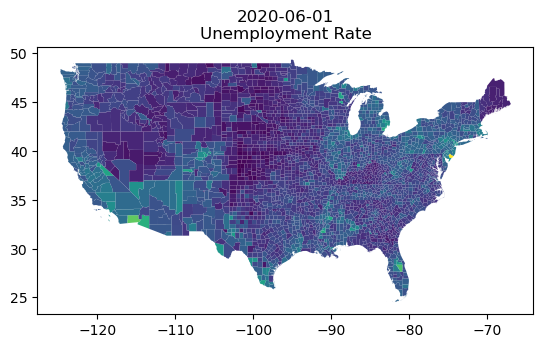

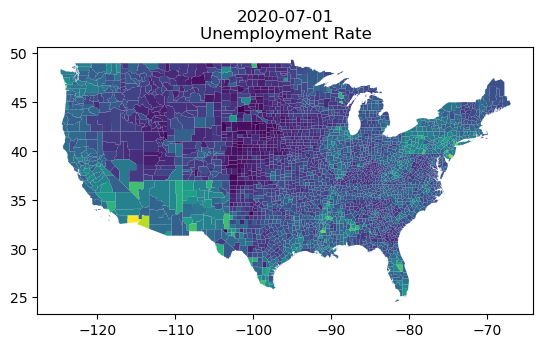

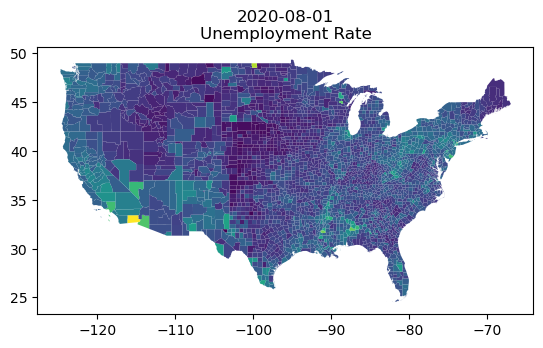

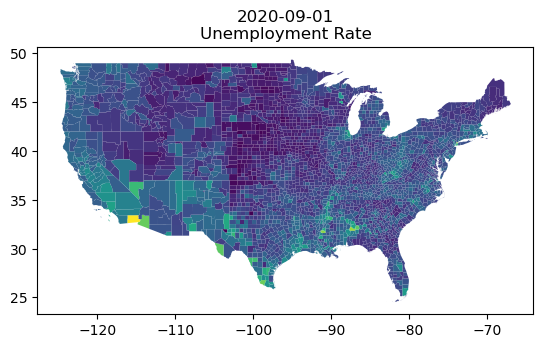

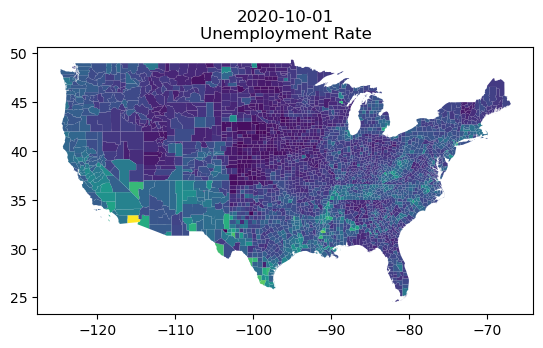

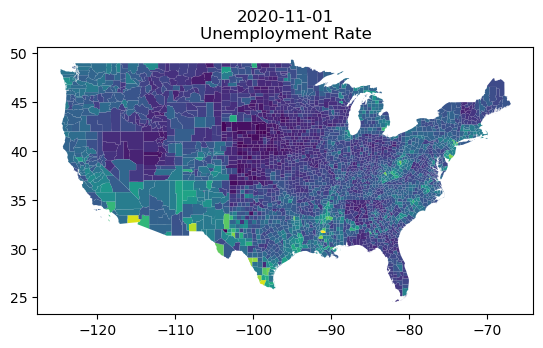

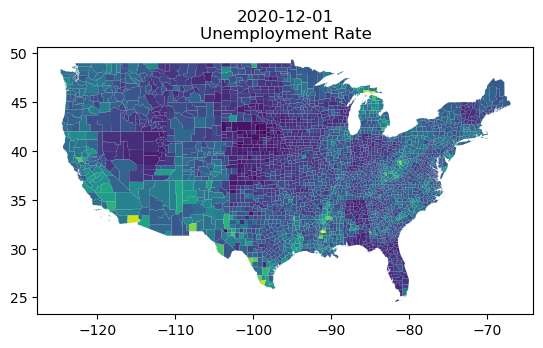

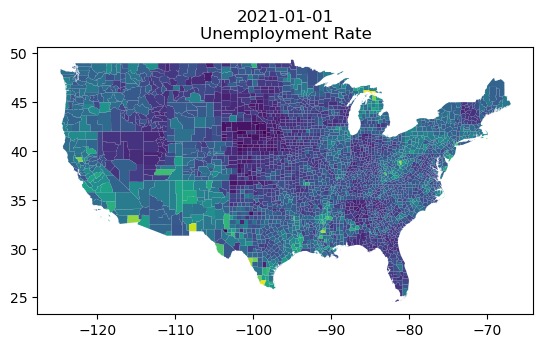

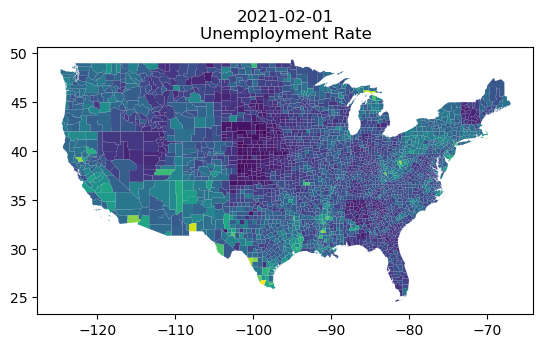

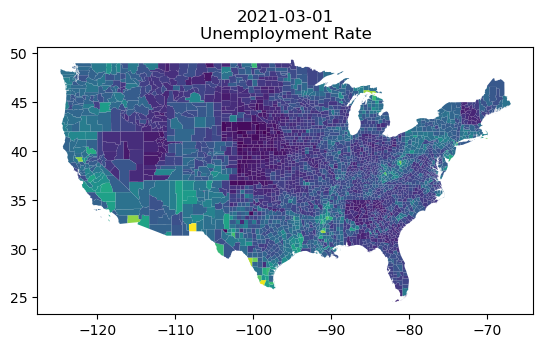

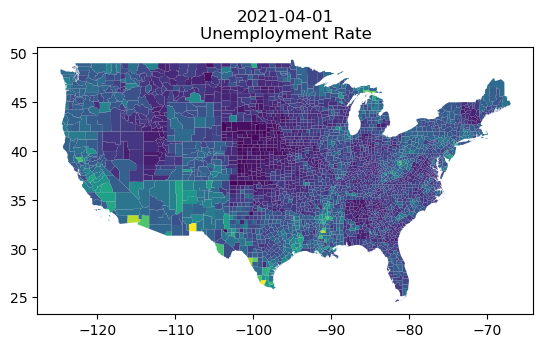

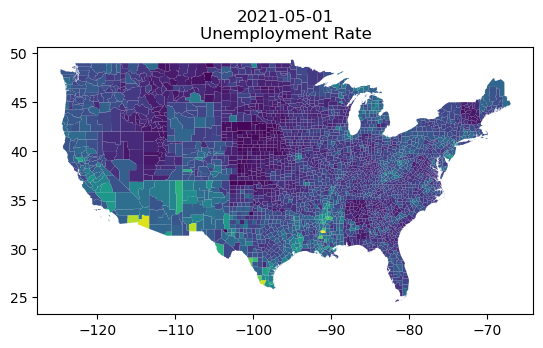

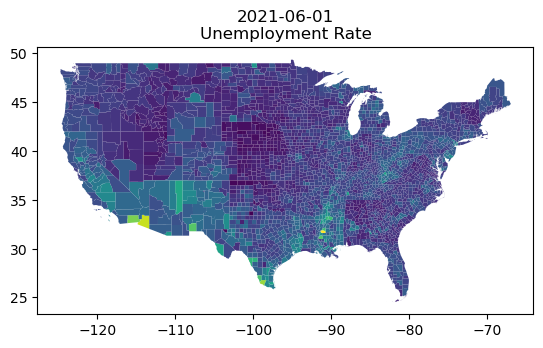

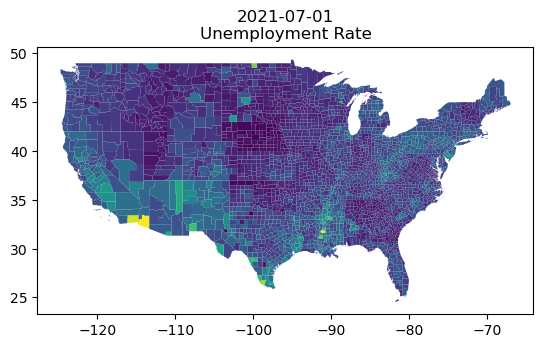

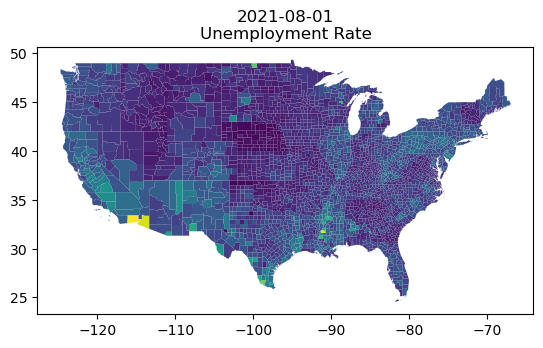

In [93]:
plot_data = u_data["Unemployment Rate"].copy()
plot_data = plot_data[~plot_data["state"].isin(["Hawaii", "Alaska"])]
for date in dates:
    plot_data.plot(column=date)
    plt.title(str(date)[:10] + "\nUnemployment Rate")

In [90]:
for key, df in u_data.items():
    u_data[key] = df[~df["state"].isin(["Hawaii", "Alaska"])]

In [92]:
sorted(u_data[key]["state"].unique())

['Alabama',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'District of Columbia',
 'Florida',
 'Georgia',
 'Idaho',
 'Illinois',
 'Indiana',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Maryland',
 'Massachusetts',
 'Michigan',
 'Minnesota',
 'Mississippi',
 'Missouri',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Jersey',
 'New Mexico',
 'New York',
 'North Carolina',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Oregon',
 'Pennsylvania',
 'Rhode Island',
 'South Carolina',
 'South Dakota',
 'Tennessee',
 'Texas',
 'Utah',
 'Vermont',
 'Virginia',
 'Washington',
 'West Virginia',
 'Wisconsin',
 'Wyoming']